# Arquitetura do Modelo 3

## Etapa 1 - Importando as bibliotecas

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import zipfile

cv2.__version__

'3.4.3'

In [ ]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

TensorFlow 2.x selected.


'2.0.0'

## Etapa 2 - Conectando com o Drive e acessando os arquivos

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
path = "/content/gdrive/My Drive/Material.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
base_imgs = 'Material/fer2013.zip'
zip_object = zipfile.ZipFile(file = base_imgs, mode = "r")
zip_object.extractall("./")
zip_object.close()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Etapa 3 - Acessando a base com fotos de expressões faciais



In [ ]:
data = pd.read_csv('fer2013/fer2013.csv')
data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


Text(0.5, 1.0, 'Imagens x emoção')

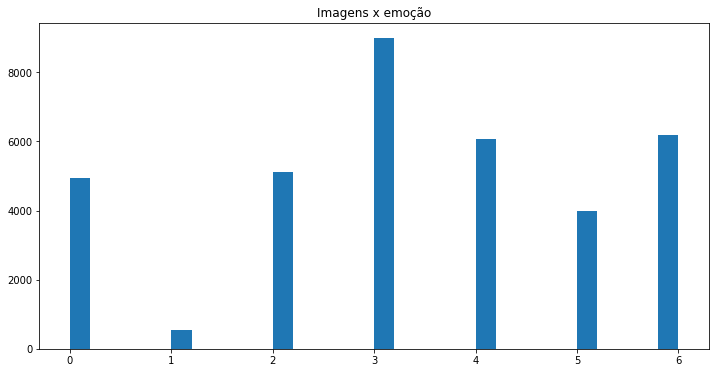

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(data['emotion'], bins=30)
plt.title("Imagens x emoção")

# Classes: ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

## Etapa 4 - Pré-processamento

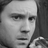

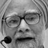

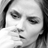

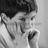

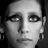

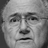

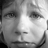

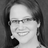

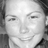

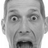

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [ ]:
pixels = data['pixels'].tolist()
largura, altura = 48, 48

faces = []
amostras = 0 
for pixel_sequence in pixels:
  face = [int(pixel) for pixel in pixel_sequence.split(' ')]
  face = np.asarray(face).reshape(largura, altura) 
  faces.append(face)
  
  if (amostras < 10):
    cv2_imshow(face)

  amostras = amostras + 1

faces = np.asarray(faces) 
faces = np.expand_dims(faces, -1)

def normalizar(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    return x

faces = normalizar(faces)
emocoes = pd.get_dummies(data['emotion']).as_matrix() 

In [ ]:
print("Número total de imagens no dataset: "+str(len(faces)))

Número total de imagens no dataset: 35887


## Etapa 5 - Imports do Tensorflow/Keras

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

## Etapa 6 - Dividir em conjuntos para treinamento e validação

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(faces, emocoes, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=41)

print("Número de imagens no conjunto de treinamento:", len(x_train))
print("Número de imagens no conjunto de testes:", len(x_test))
print("Número de imagens no conjunto de validação:", len(y_val))

Número de imagens no conjunto de treinamento: 29068
Número de imagens no conjunto de testes: 3589
Número de imagens no conjunto de validação: 3230


In [ ]:
np.save('mod_xtest', x_test)
np.save('mod_ytest', y_test)

## Etapa 7 - Arquitetura do Modelo (CNN)

### Arquitetura do modelo

Implementação original: https://medium.com/themlblog/how-to-do-facial-emotion-recognition-using-a-cnn-b7bbae79cd8f

In [ ]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 128)       5

## Etapa 8 - Compilando o modelo 

In [ ]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])
arquivo_modelo = "modelo_03_expressoes.h5"
arquivo_modelo_json = "modelo_03_expressoes.json"
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(arquivo_modelo, monitor='val_loss', verbose=1, save_best_only=True)

### Salvando a arquitetura do modelo em um arquivo JSON

In [ ]:
model_json = model.to_json()
with open(arquivo_modelo_json, "w") as json_file:
    json_file.write(model_json)

## Etapa 9 - Treinando o modelo

In [ ]:
history = model.fit(np.array(x_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(x_val), np.array(y_val)),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, checkpointer])

Train on 29068 samples, validate on 3230 samples
Epoch 1/100
28992/29068 [============================>.] - ETA: 0s - loss: 1.9886 - accuracy: 0.2089
Epoch 00001: val_loss improved from inf to 1.82420, saving model to modelo_03_expressoes.h5
29068/29068 [==============================] - 19s 659us/sample - loss: 1.9882 - accuracy: 0.2090 - val_loss: 1.8242 - val_accuracy: 0.2594
Epoch 2/100
28992/29068 [============================>.] - ETA: 0s - loss: 1.8356 - accuracy: 0.2443
Epoch 00002: val_loss improved from 1.82420 to 1.80954, saving model to modelo_03_expressoes.h5
29068/29068 [==============================] - 13s 451us/sample - loss: 1.8355 - accuracy: 0.2445 - val_loss: 1.8095 - val_accuracy: 0.2594
Epoch 3/100
28992/29068 [============================>.] - ETA: 0s - loss: 1.8164 - accuracy: 0.2507
Epoch 00003: val_loss did not improve from 1.80954
29068/29068 [==============================] - 13s 443us/sample - loss: 1.8164 - accuracy: 0.2508 - val_loss: 1.8307 - val_accura

## Gerando gráfico da melhora em cada etapa do treinamento

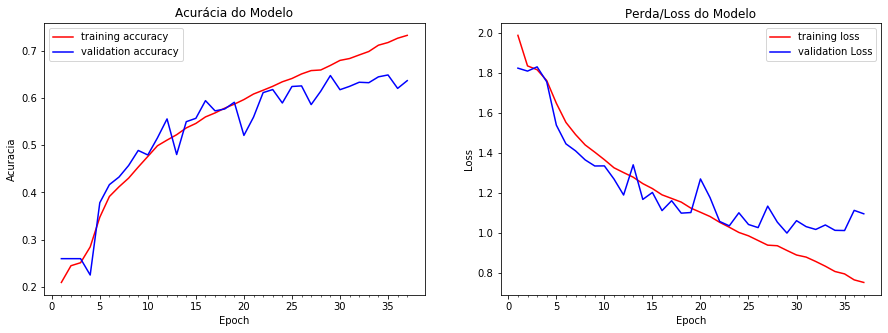

In [ ]:
def plota_historico_modelo(historico_modelo):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(historico_modelo.history['accuracy'])+1),
                historico_modelo.history['accuracy'],'r')
    axs[0].plot(range(1,len(historico_modelo.history['val_accuracy'])+1),
                historico_modelo.history['val_accuracy'],'b')
    axs[0].set_title('Acurácia do Modelo')
    axs[0].set_ylabel('Acuracia')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(historico_modelo.history['accuracy'])+1),
                      len(historico_modelo.history['accuracy'])/10)
    axs[0].legend(['training accuracy', 'validation accuracy'], loc='best')

    axs[1].plot(range(1,len(historico_modelo.history['loss'])+1),
                historico_modelo.history['loss'],'r')
    axs[1].plot(range(1,len(historico_modelo.history['val_loss'])+1),
                historico_modelo.history['val_loss'],'b')
    axs[1].set_title('Perda/Loss do Modelo')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(historico_modelo.history['loss'])+1),
                      len(historico_modelo.history['loss'])/10)
    axs[1].legend(['training loss', 'validation Loss'], loc='best')
    fig.savefig('historico_modelo_mod01.png')
    plt.show()

plota_historico_modelo(history)

### Verificando a acurácia do modelo

In [ ]:
scores = model.evaluate(np.array(x_test), np.array(y_test), batch_size=batch_size)
print("Acurácia: " + str(scores[1]))
print("Perda/Loss: " + str(scores[0]))

3589/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Carregaremos os dados para gerar a matriz de confusão

In [ ]:
true_y=[]
pred_y=[]
x = np.load('mod_xtest.npy')
y = np.load('mod_ytest.npy')
json_file = open(arquivo_modelo_json, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(arquivo_modelo)
y_pred= loaded_model.predict(x)
yp = y_pred.tolist()
yt = y.tolist()
count = 0
for i in range(len(y)):
    yy = max(yp[i])
    yyt = max(yt[i])
    pred_y.append(yp[i].index(yy))
    true_y.append(yt[i].index(yyt))
    if(yp[i].index(yy)== yt[i].index(yyt)):
        count+=1
acc = (count/len(y))*100
np.save('truey__mod01', true_y)
np.save('predy__mod01', pred_y)
print("Acurácia no conjunto de testes: "+str(acc)+"%")

Acurácia no conjunto de testes: 62.97018668152688%


## Gerando a Matriz de Confusão

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = np.load('truey__mod01.npy')
y_pred = np.load('predy__mod01.npy')
cm = confusion_matrix(y_true, y_pred)
expressoes = ["Raiva", "Nojo", "Medo", "Feliz", "Triste", "Surpreso", "Neutro"]
titulo='Matriz de Confusão'
print(cm)

[[281   0  32  22  97  11  55]
 [ 28  12   2   0   8   1   1]
 [ 84   3 150  28 173  59  48]
 [ 26   0   3 768  29  22  33]
 [ 50   0  27  40 359   2 110]
 [ 12   0  47  34   9 300  12]
 [ 29   0  10  53 123   6 390]]


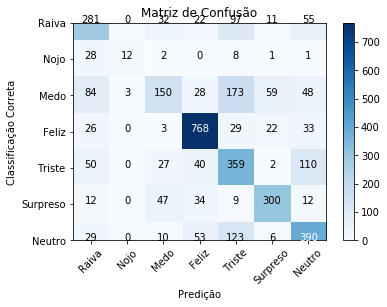

In [ ]:
import itertools
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(titulo)
plt.colorbar()
tick_marks = np.arange(len(expressoes))
plt.xticks(tick_marks, expressoes, rotation=45)
plt.yticks(tick_marks, expressoes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classificação Correta')
plt.xlabel('Predição')
plt.savefig('matriz_confusao_mod01.png')
plt.show()

## Testando brevemente o modelo

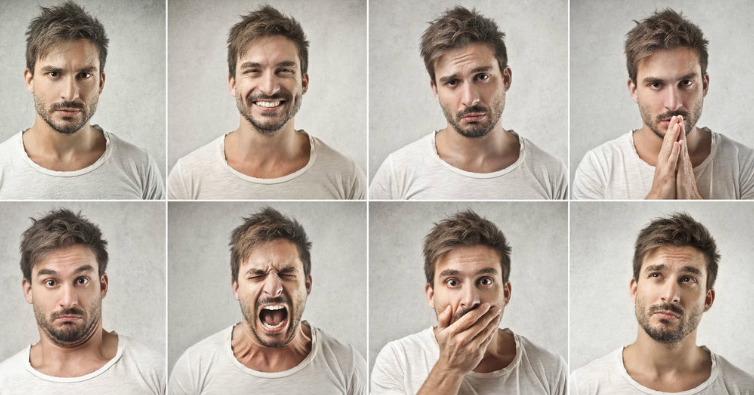

In [ ]:
imagem = cv2.imread("Material/testes/teste02.jpg")
cv2_imshow(imagem)

In [ ]:
model = load_model("modelo_03_expressoes.h5") # carrega o modelo
scores = model.evaluate(np.array(x_test), np.array(y_test), batch_size=batch_size)
print("Perda/Loss: " + str(scores[0]))
print("Acurácia: " + str(scores[1]))

3589/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

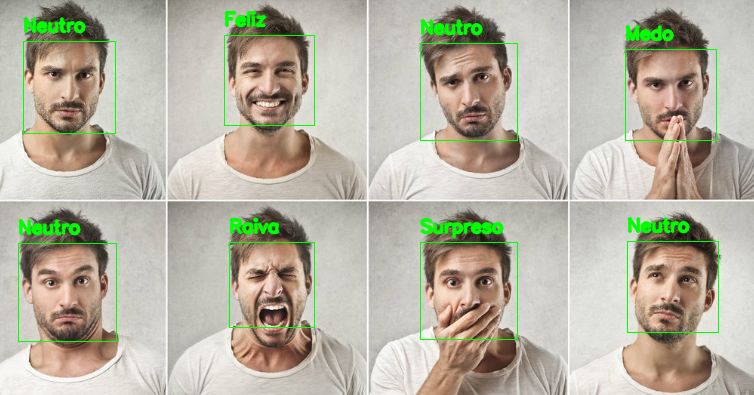

In [ ]:
expressoes = ["Raiva", "Nojo", "Medo", "Feliz", "Triste", "Surpreso", "Neutro"]
original = imagem.copy()
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier('Material/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.1, 3)
for (x, y, w, h) in faces:
    cv2.rectangle(original, (x, y), (x + w, y + h), (0, 255, 0), 1)
    roi_gray = gray[y:y + h, x:x + w]
    roi_gray = roi_gray.astype("float") / 255.0
    cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
    cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, 
                  norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
    prediction = model.predict(cropped_img)[0]
    cv2.putText(original, expressoes[int(np.argmax(prediction))], (x, y - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)
cv2_imshow(original)